# Description on original DECA outputs 

In [1]:
import torch
import numpy as np
import pickle
import glob
import skimage.transform
import cv2
import os

In [2]:
# original output dictionaries of DECA
dataset = []
for fp in glob.glob(os.path.abspath('./TestSamples/examples/results/1019_11/data_*.pkl')):
    dataset.append(pickle.load(open(fp, 'rb')))
codedict = torch.load(os.path.abspath('./TestSamples/examples/results/1019_11/codedict.pt'))
opdict = torch.load(os.path.abspath('./TestSamples/examples/results/1019_11/opdict.pt'))
visdict = torch.load(os.path.abspath('./TestSamples/examples/results/1019_11/visdict.pt'))

# Dataset instance Description

- image: cropped (face segmented) image
- imagename
- tform: estimated Transformation of skimage. source points from cropped region in original image, destination points from after-crop image size
- center: center point of cropped region in original image
- size: scaled size of cropped region in original image
- original_image: original image given to the model

In [12]:
for data in dataset:
    for k, v in data.items():
        if type(v) in [torch.Tensor, np.ndarray]:
            print(k,': shape', v.shape, type(v))
        else:
            print(k,': ', v, type(v))        
    print('-'*100)

image : shape torch.Size([3, 224, 224]) <class 'torch.Tensor'>
imagename :  1019_11 <class 'str'>
tform :  <SimilarityTransform(matrix=
    [[   0.69470405,    0.        ,  -84.05919003],
     [   0.        ,    0.69470405, -134.42523364],
     [   0.        ,    0.        ,    1.        ]])> <class 'skimage.transform._geometric.SimilarityTransform'>
center : shape (2,) <class 'numpy.ndarray'>
size :  321 <class 'int'>
original_image : shape torch.Size([3, 800, 600]) <class 'torch.Tensor'>
----------------------------------------------------------------------------------------------------


# codedict Description
batch size N, # of vertices V, # of channels C, height H, width W

- shape: shape parameter of FLAME. N, (100 dim)
- tex: texture embedding(latent code) of FLAME w/ texture. N, (50 dim)
- exp:  expression parameter of FLAME. N, (50 dim)
- pose: pose parameter of FLAME. N, (6 dim)
    - [:,3]: global pose in angle axis
    - [:,3:]: jaw pose in angle axis
- cam: camera parameter of orthographic camera model. $\bf{s}\in \mathbb{R}$ isotropic scale.
$\bf{t}\in\mathbb{R}^2$ 2D translation. $\bf{c}=(\bf{s}, \bf{t})\in\mathbb{R}^3$. N, (3 dim)
- light: lightening parameter for Spherical Harmonics (SH) illumination model. N, (9 dim), (3 dim)
- images: face segmented image. N, C=3, H, W
- detail: detail embedding(latent code) for rendering detail displacement map. N, (128 dim)

In [4]:
for k, v in codedict.items():
    print(k, ': ', v.shape)

shape :  torch.Size([1, 100])
tex :  torch.Size([1, 50])
exp :  torch.Size([1, 50])
pose :  torch.Size([1, 6])
cam :  torch.Size([1, 3])
light :  torch.Size([1, 9, 3])
images :  torch.Size([1, 3, 224, 224])
detail :  torch.Size([1, 128])


## pose example
(batch_euler2axis(deg2rad(euler_pose[:,:3].cuda())) should be applied) <br>
<b>neck pose of FLAME is not considered in DECA. (fixed w/ default zero values)</b>

<br>
<div>
    <table>
        <tr>
            <th>pose[:,0] = 90</th>
            <th>pose[:,1] = 90</th>
            <th>pose[:,2] = 90</th>
        </tr>
        <tr>
            <td>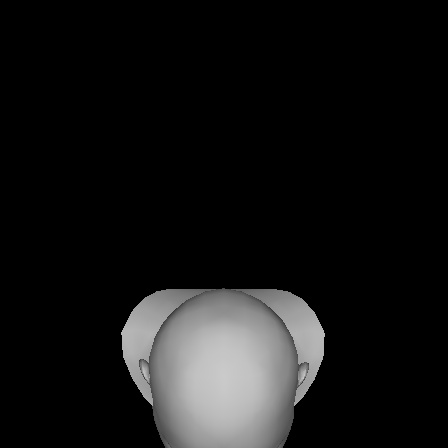</td>
            <td>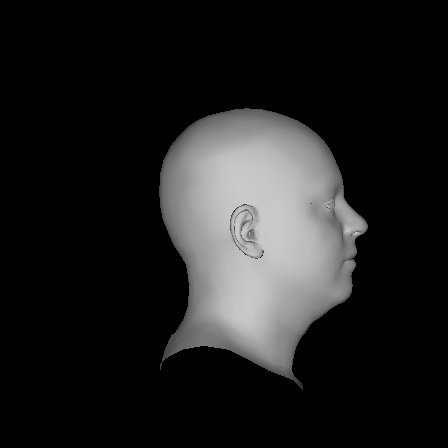</td>
            <td>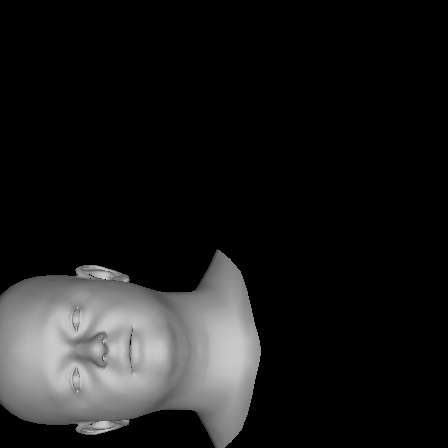</td>
        </tr>
        <tr>
            <th>pose[:,3] = 30</th>
            <th>pose[:,4] = 30</th>
            <th>pose[:,5] = 30</th>
        </tr>
        <tr>
            <td>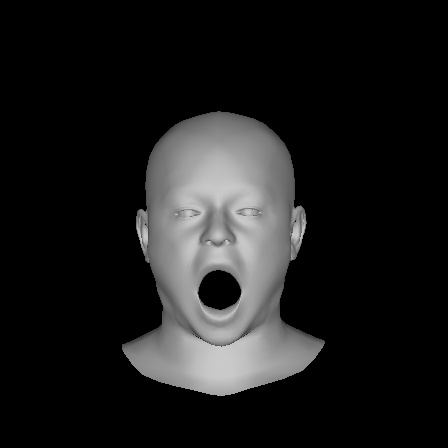</td>
            <td>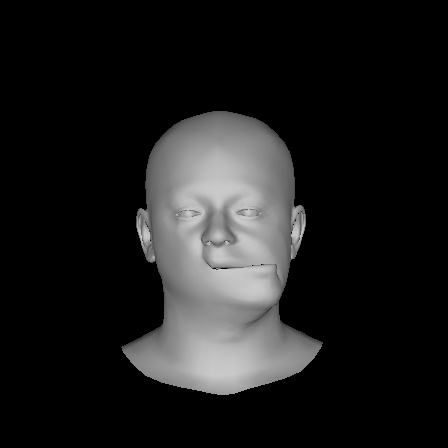</td>
            <td>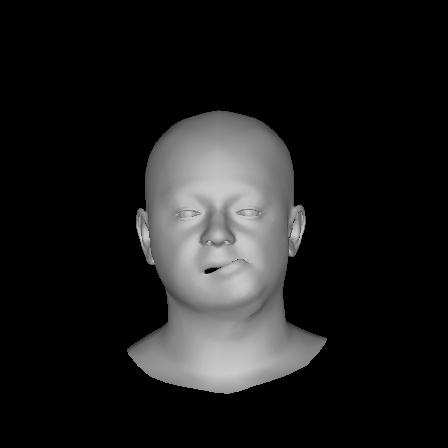</td>
        </tr>
    </table>
</div>

## camera example

<div>
    <table>
        <tr>
            <th>cam[:,:] = 1., 0., 0.</th>
            <th>cam[:,:] = 10., 0., 0.</th>
        </tr>
        <tr>
            <td>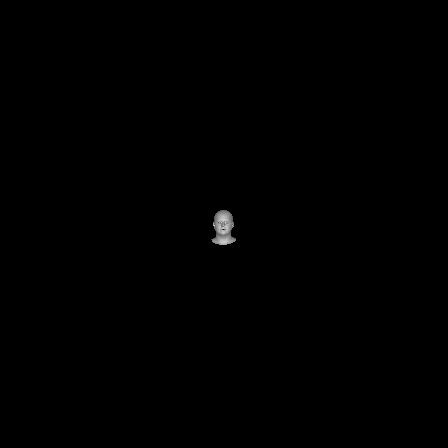</td>
            <td>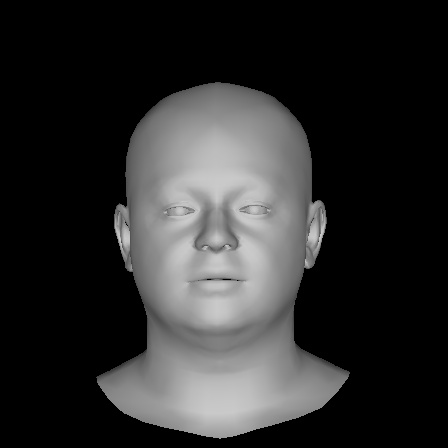</td>
        </tr>
        <tr>
            <th>cam[:,:] = 8., 0., 0.</th>
            <th>cam[:,:] = 8., 0.2, 0.</th>
            <th>cam[:,:] = 8., 0., 0.2</th>
        </tr>
        <tr>
            <td>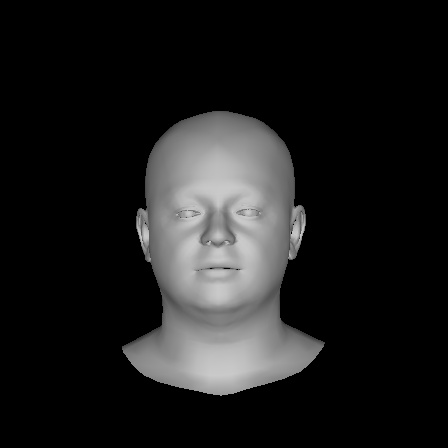</td>
            <td>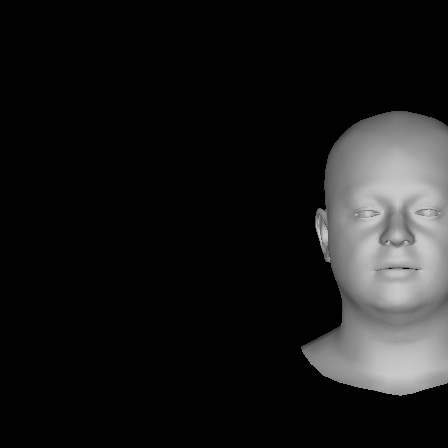</td>
            <td>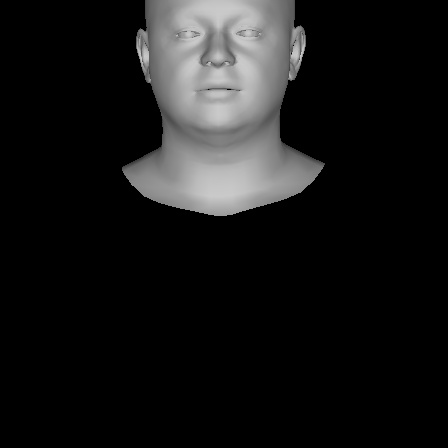</td>
        </tr>
    </table>
</div>

# opdict Description
batch size N, # of vertices V=5023, # of channels C, height H, width W

- verts: vertices. N, V, (3 dim)
- tran_verts: projected vertices. N, V, (3 dim)
- landmarks2d: 2d landmarks in uv coor. N, V, (2 dim)
- landmarks3d: projected 3d landmarks concat with visibility calculated based on norm. N, V, (3 dim + 1 visibility(1. or 0.))
- landmarks3d_world: 3d landmarks in world(xyz) coor. N, V, (3 dim)
- grid: grid tensor to specify input pixel locations x and y, which are used to interpolate the output value. N, H_{out}, W_{out}, (2 dim) 
- rendered_images: N, C=3, H, W
- alpha_images: N, C=1, H, W
- normal_images: N, C=3, H, W
- albedo :  N, C=3, H, W
- uv_texture :  N, C=3, H, W 
- normals :  N, V, (3 dim)
- uv_detail_normals :  N, C=3, H, W
- displacement_map :  N, C=1, H, W
- uv_texture_gt :  N, C=3, H, W

In [6]:
for k, v in opdict.items():
    print(k, ': ', v.shape)

verts :  torch.Size([1, 5023, 3])
trans_verts :  torch.Size([1, 5023, 3])
landmarks2d :  torch.Size([1, 68, 2])
landmarks3d :  torch.Size([1, 68, 4])
landmarks3d_world :  torch.Size([1, 68, 3])
grid :  torch.Size([1, 224, 224, 2])
rendered_images :  torch.Size([1, 3, 224, 224])
alpha_images :  torch.Size([1, 1, 224, 224])
normal_images :  torch.Size([1, 3, 224, 224])
albedo :  torch.Size([1, 3, 256, 256])
uv_texture :  torch.Size([1, 3, 256, 256])
normals :  torch.Size([1, 5023, 3])
uv_detail_normals :  torch.Size([1, 3, 256, 256])
displacement_map :  torch.Size([1, 1, 256, 256])
uv_texture_gt :  torch.Size([1, 3, 256, 256])


# visdict Description
batch size N, # of channels C <br>
all shape batch size N, # of channel C=3, height H, width W

- inputs
- landmarks2d
- landmarks3d
- shape_images
- shape_detail_images
- depth_images
- rendered_images

In [8]:
for k, v in visdict.items():
    print(k, ': ', v.shape)

inputs :  torch.Size([1, 3, 224, 224])
landmarks2d :  torch.Size([1, 3, 224, 224])
landmarks3d :  torch.Size([1, 3, 224, 224])
shape_images :  torch.Size([1, 3, 224, 224])
shape_detail_images :  torch.Size([1, 3, 224, 224])
shifted_shape_lt :  torch.Size([1, 3, 224, 224])
shifted_shape_rt :  torch.Size([1, 3, 224, 224])
shifted_shape_lb :  torch.Size([1, 3, 224, 224])
shifted_shape_rb :  torch.Size([1, 3, 224, 224])
rendered_images :  torch.Size([1, 3, 224, 224])


## landmark example
<div>
    <img src="https://user-images.githubusercontent.com/31180090/44790959-39a90100-aba9-11e8-8425-448561070e8a.png" width="400"/>
</div>

In [4]:
import numpy as np
import cv2

end_list = np.array([17, 22, 27, 42, 48, 31, 36, 68], dtype = np.int32) - 1
def plot_kpts(image, kpts, color = 'r'):
    ''' Draw 68 key points
    Args: 
        image: the input image
        kpt: (68, 3).
    '''
    if color == 'r':
        c = (255, 0, 0)
    elif color == 'g':
        c = (0, 255, 0)
    elif color == 'b':
        c = (255, 0, 0)
    image = image.copy()
    kpts = kpts.copy()
    for i in range(kpts.shape[0]):
        st = kpts[i, :2]
        if kpts.shape[1]==4:
            if kpts[i, 3] > 0.5:
                c = (0, 255, 0)
            else:
                c = (0, 0, 255)
        image = cv2.circle(image,(int(st[0]), int(st[1])), 1, c, 2)  
        if i in end_list:
            continue
        ed = kpts[i + 1, :2]
        image = cv2.line(image, (int(st[0]), int(st[1])), (int(ed[0]), int(ed[1])), (255, 255, 255), 1)

    return image

def tensor_vis_landmarks(images, landmarks, gt_landmarks=None, color = 'g', isScale=True):
    # visualize landmarks
    # red color for unvisible ones
    vis_landmarks = []
    images = images.cpu().numpy()
    predicted_landmarks = landmarks.detach().cpu().numpy()
    if gt_landmarks is not None:
        gt_landmarks_np = gt_landmarks.detach().cpu().numpy()
    for i in range(images.shape[0]):
        image = images[i]
        image = image.transpose(1,2,0)[:,:,[2,1,0]].copy(); image = (image*255)
        if isScale:
            predicted_landmark = predicted_landmarks[i]
            predicted_landmark[...,0] = predicted_landmark[...,0]*image.shape[1]/2 + image.shape[1]/2
            predicted_landmark[...,1] = predicted_landmark[...,1]*image.shape[0]/2 + image.shape[0]/2
        else:
            predicted_landmark = predicted_landmarks[i]
        if predicted_landmark.shape[0] == 68:
            image_landmarks = plot_kpts(image, predicted_landmark, color)
            if gt_landmarks is not None:
                image_landmarks = plot_verts(image_landmarks, gt_landmarks_np[i]*image.shape[0]/2 + image.shape[0]/2, 'r')
        else:
            image_landmarks = plot_verts(image, predicted_landmark, color)
            if gt_landmarks is not None:
                image_landmarks = plot_verts(image_landmarks, gt_landmarks_np[i]*image.shape[0]/2 + image.shape[0]/2, 'r')
        vis_landmarks.append(image_landmarks)

    vis_landmarks = np.stack(vis_landmarks)
    vis_landmarks = torch.from_numpy(vis_landmarks[:,:,:,[2,1,0]].transpose(0,3,1,2))/255.#, dtype=torch.float32)
    return vis_landmarks

In [5]:
def tensor2image(tensor):
    image = tensor.detach().cpu().numpy()
    image = image*255.
    image = np.maximum(np.minimum(image, 255), 0)
    image = image.transpose(1,2,0)[:,:,[2,1,0]]
    return image.astype(np.uint8).copy()

In [6]:
def transform_points(points, tform, points_scale=None, out_scale=None):
    points_2d = points[:,:,:2]
        
    #'input points must use original range'
    if points_scale:
        assert points_scale[0]==points_scale[1]
        points_2d = (points_2d*0.5 + 0.5)*points_scale[0]
    # import ipdb; ipdb.set_trace()

    batch_size, n_points, _ = points.shape
    trans_points_2d = torch.bmm(
                    torch.cat([points_2d, torch.ones([batch_size, n_points, 1], device=points.device, dtype=points.dtype)], dim=-1), 
                    tform
                    ) 
    if out_scale: # h,w of output image size
        trans_points_2d[:,:,0] = trans_points_2d[:,:,0]/out_scale[1]*2 - 1
        trans_points_2d[:,:,1] = trans_points_2d[:,:,1]/out_scale[0]*2 - 1
    trans_points = torch.cat([trans_points_2d[:,:,:2], points[:,:,2:]], dim=-1)
    return trans_points

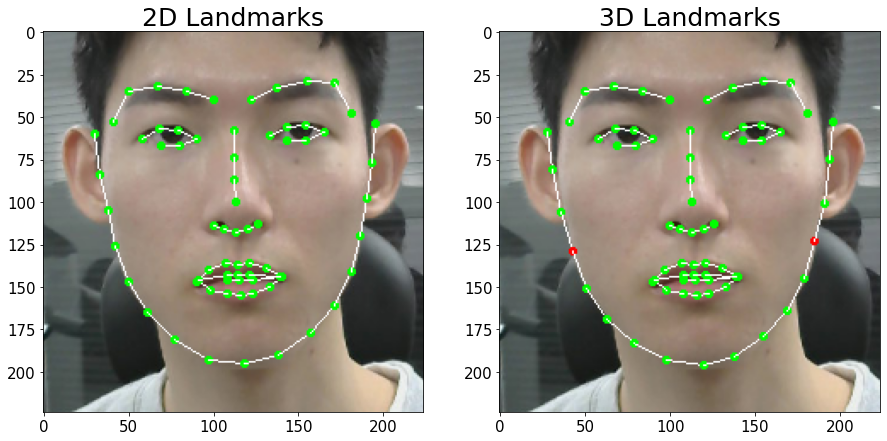

In [10]:
from matplotlib import pyplot as plt

img2d = tensor2image(tensor_vis_landmarks(visdict['inputs'], opdict['landmarks2d'])[0]) # or codedict['images']
img3d = tensor2image(tensor_vis_landmarks(visdict['inputs'], opdict['landmarks3d'])[0])

# cv2.imshow('image',img2d)
# cv2.waitKey(0)
# cv2.imshow('image',img3d)
# cv2.waitKey(0)

img2d = img2d[:,:,::-1]
img3d = img3d[:,:,::-1]

f, axes = plt.subplots(1,2, figsize=(15, 30))

axes[0].set_title('2D Landmarks', fontsize=25)
axes[0].imshow(img2d)
axes[0].tick_params(axis='both', labelsize=15)
axes[1].set_title('3D Landmarks', fontsize=25)
axes[1].imshow(img3d)
axes[1].tick_params(axis='both', labelsize=15)

# cv2.imwrite(wfp, res)

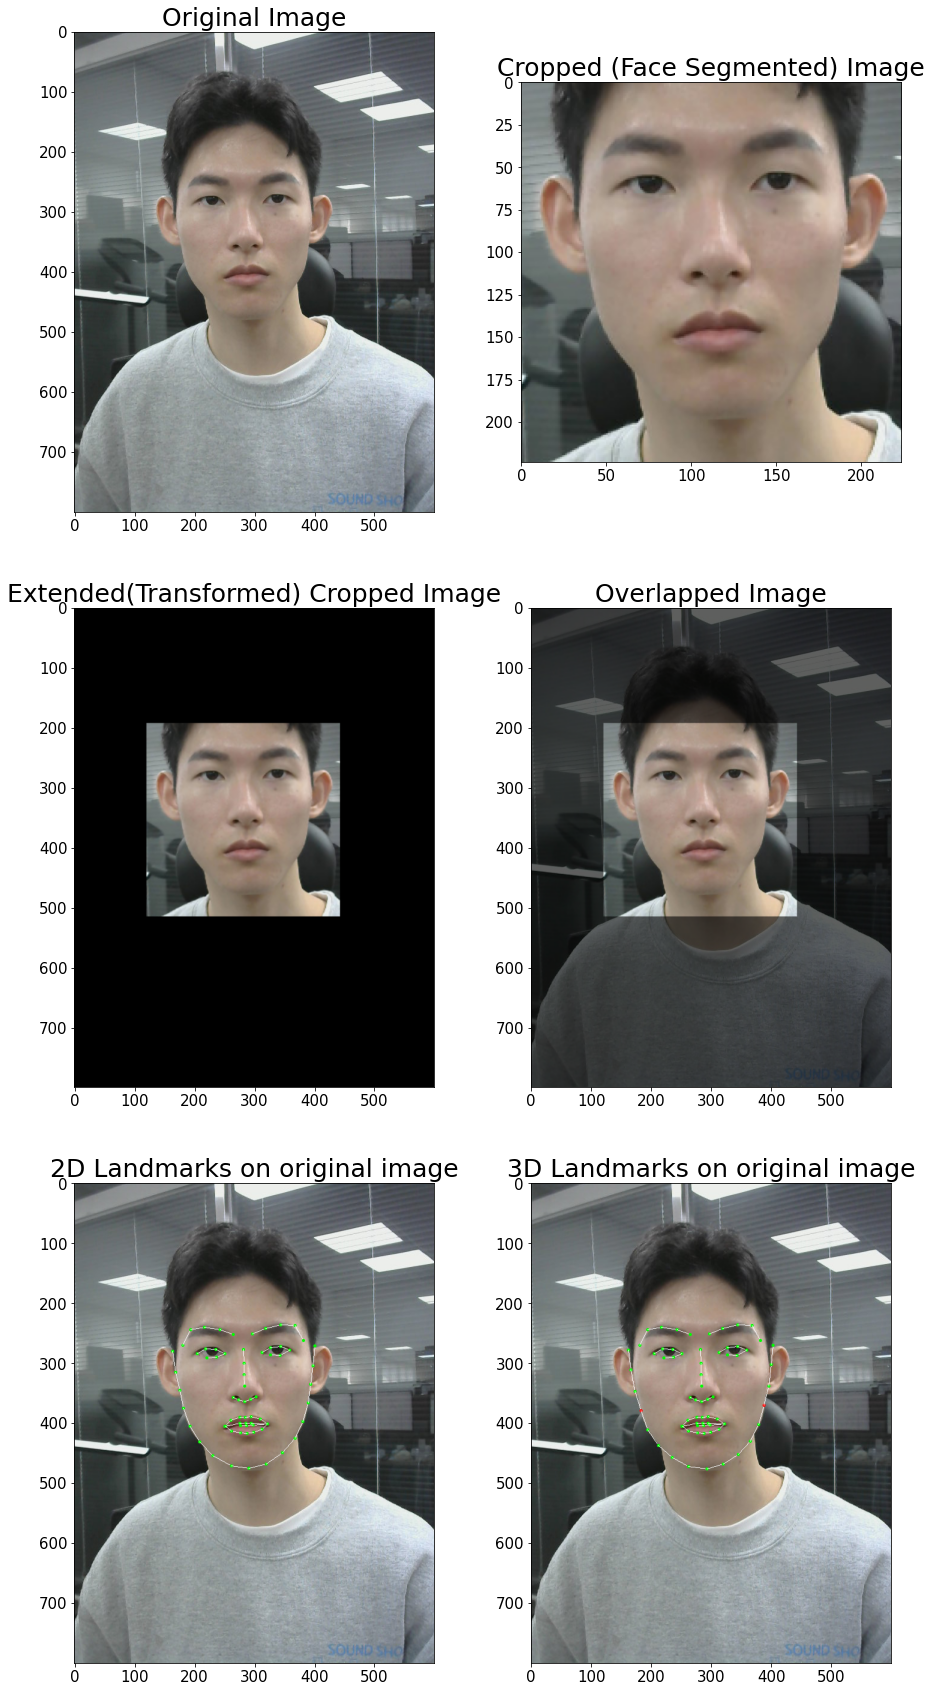

In [8]:
# tform = torch.tensor(dataset[0]['tform'].params)[None, ...]
# tform = torch.inverse(tform).transpose(1,2) #.to(device)

device = 'cuda'

org_img = tensor2image(dataset[0]['original_image']) # or codedict['images']
crop_img = tensor2image(visdict['inputs'][0])

tform = dataset[0]['tform']

points_scale = visdict['inputs'].shape[2:]
_, h, w = dataset[0]['original_image'].shape

# transfrom image
extended_crop_img = skimage.transform.warp(visdict['inputs'][0].detach().cpu().numpy().transpose(1,2,0), 
                    tform, 
                    output_shape=(h, w))
extended_crop_img = (extended_crop_img*255.).astype(np.uint8)

alpha = 0.6
overlay_img = cv2.addWeighted(org_img[:,:,::-1], 1 - alpha, extended_crop_img, alpha, 0)

# transform landmarks
inv_trans_param = torch.tensor(tform.params).float()[None, ...]
inv_trans_param = torch.inverse(inv_trans_param).transpose(1,2).to(device) #inv_trans_param.transpose(1,2).to(device) 
trans_landmarks2d = transform_points(opdict['landmarks2d'], inv_trans_param, points_scale, [h, w])
trans_landmarks3d = transform_points(opdict['landmarks3d'], inv_trans_param, points_scale, [h, w])

# plot landmarks
img_ldmk_2d = tensor2image(tensor_vis_landmarks(dataset[0]['original_image'][None, ...], trans_landmarks2d)[0])
img_ldmk_3d = tensor2image(tensor_vis_landmarks(dataset[0]['original_image'][None, ...], trans_landmarks3d)[0])


# plot images
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
f, axes = plt.subplots(3,2, figsize=(15, 30))

org_img = org_img[:,:,::-1]
crop_img = crop_img[:,:,::-1]
img_ldmk_2d = img_ldmk_2d[:,:,::-1]
img_ldmk_3d = img_ldmk_3d[:,:,::-1]

axes[0,0].set_title('Original Image', fontsize=25)
axes[0,0].imshow(org_img)
axes[0,1].set_title('Cropped (Face Segmented) Image', fontsize=25)
axes[0,1].imshow(crop_img)
axes[1,0].set_title('Extended(Transformed) Cropped Image', fontsize=25)
axes[1,0].imshow(extended_crop_img)
axes[1,1].set_title('Overlapped Image', fontsize=25)
axes[1,1].imshow(overlay_img)
axes[2,0].set_title('2D Landmarks on original image', fontsize=25)
axes[2,0].imshow(img_ldmk_2d)
axes[2,1].set_title('3D Landmarks on original image', fontsize=25)
axes[2,1].imshow(img_ldmk_3d)